# Export a dynamical decoupling sequence to Cirq

[Q-CTRL Open Controls](https://github.com/qctrl/python-open-controls) provides easy-to-use methods to construct dynamical decoupling sequences (DDS) according to well-known dynamical decoupling schemes. Here we show how a DDS from Q-CTRL Open Controls can be exported as a `Circuit` or `Schedule` and run in the `Simulator` using the Q-CTRL Cirq Adapter package.

Note: 
* You will need [Cirq](https://cirq.readthedocs.io/en/stable/) to create the quantum circuits in this notebook and run the simulations.

## Imports

In [1]:
# General
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Q-CTRL Open Controls
from qctrlopencontrols import new_predefined_dds

# Q-CTRL Cirq Adapter
from qctrlcirq import convert_dds_to_cirq_circuit, convert_dds_to_cirq_schedule

# Q-CTRL Visualizer
from qctrlvisualizer import plot_sequences

# Cirq : to run the circuit on simulator
import cirq

## Running a DDS on a Cirq Simulator

This section demonstrates how a DDS can be prepared, a corresponding quantum circuit made and executed on a `cirq` simulator.

Q-CTRL Open Controls defines a DDS as a set of instantaneous unitary operations performed at specific offset times, see the [technical documentation](https://docs.q-ctrl.com/open-controls/references/qctrl-open-controls/qctrlopencontrols/DynamicDecouplingSequence.html) for mathematical details.

`cirq` implements quantum operations through a series of [gates](https://cirq.readthedocs.io/en/stable/gates.html). The standard way to create a quantum circuit is using `Circuit`. If a user wants to add pauses (in time) to a `Circuit` computation they can use identity gates. Alternatively, `cirq` provides `ScheduledOperation` that specifies an operation (application of a gate on one or more qubits) at a certain instant measured in ns or ps from the start of the sequence. A list of `ScheduledOperation` is collated by `Schedule`. Both `Circuit` and `Schedule` can be used in `Simulator` to simulate the circuit. We support both options through two methods: `convert_dds_to_cirq_circuit` and `covert_dds_to_cirq_schedule`.

Converting a DDS into a `Circuit` or `Schedule` is an approximate process where the instantaneous unitaries are replaced with finite duration gates. Moreover, in `Circuit`, the pauses in-between unitaries are replaced with the closest integer number of identity gates. The exact algorithm used to make this approximation is documented in the [source code](https://github.com/qctrl/python-cirq).

In this example we will define a Quadratic DDS and convert it into a circuit that we can later run on a simulator. Note that we add a $X_{\pi/2}$ rotation at both ends of the sequence.

### Preparing the sequences

In [2]:
## Quadratic sequence, total duration: 20us
quadratic_sequence = new_predefined_dds(
    scheme="quadratic",
    duration=20e-6,
    number_inner_offsets=2,
    number_outer_offsets=2,
    pre_post_rotation=True,
    name="Quadratic sequence",
)
print(quadratic_sequence)

Quadratic sequence:
Duration = 2e-05
Offsets = [0.0,0.06249999999999998,0.18749999999999994,0.24999999999999994,0.37499999999999994,0.6249999999999999,0.7499999999999999,0.8124999999999999,0.9375,1.0] x 2e-05
Rabi Rotations = [0.5,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.5] x pi
Azimuthal Angles = [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0] x pi
Detuning Rotations = [0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0] x pi


### Constructing the circuit using Q-CTRL Open Controls

To construct a circuit/schedule from a DDS we need:
* `dynamic_decoupling_sequence` - a DDS. 
* `target_qubits` - a list of target qubits (each of `cirq.Qid` type) for the DDS.
* `gate_time` - the delay (in seconds) introduced by each of the gates. 
* (optional) `add_measurement` - to add a measurement at the end of the quantum circuit.

In this example we convert a DDS into a `cirq.Circuit`. The `gate_time` is $0.4$ $\mu$s.

In [3]:
## Prepare the conversion related parameters
"""
target_qubits : list
    A list of cirq.Qid. In this case we are using a single
    qubit (indexed 0) on 1-D lattice.
"""
target_qubits = [cirq.LineQubit(0)]


"""
gate_time : float
    Time delay (in seconds) introduced by identity gate
"""
gate_time = 0.4e-6

"""
add_measurement : bool
    Indicates if the circuit requires a measurement step.
    Required for 'qasm_simulator' and real device backends
"""
add_measurement = True

## convert the quadratic sequence to cirq.Circuit
quadratic_cirq_circuit = convert_dds_to_cirq_circuit(
    dynamic_decoupling_sequence=quadratic_sequence,
    target_qubits=target_qubits,
    gate_time=gate_time,
    add_measurement=add_measurement,
)

### Plotting the DDS

We can use the Q-CTRL Python Visualizer package to plot the DDS for comparison against its `cirq.Circuit` approximations.

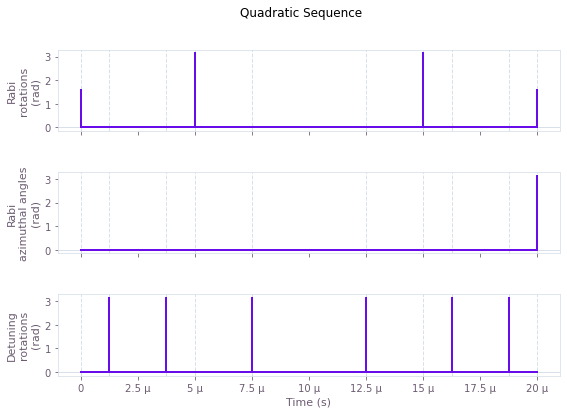

In [5]:
formatted_plot_data = quadratic_sequence.export()
figure = plt.figure()
plt.suptitle("Quadratic Sequence")
plot_sequences(figure, formatted_plot_data)

### Drawing the Circuit

We can draw a text diagram of the `cirq.Circuit` generated by Q-CTRL Open Controls.

Note that a $X_{\pi/2}$ rotation is added at beginning and end to create and remove a superposition state that is preserved by the DDS. The $X_{\pi/2}$ rotations are implemented using $Rx(0.5\pi)$ gate.

The $Rz(\pi)$ gates are $Z_\pi$ pulses (a $\pi$ rotation around $Z$-axis) and $Rx(\pi)$ gates correspond to $X_{\pi}$ pulses (a $\pi$ rotation around $X$-axis).

The `I` in the drawing corresponds to the `identity` gate. In the DDS, the first $Z_{\pi}$-pulse is applied at a delay of $1.25$ $\mu$s. This is approximated by introducing 3-`Id` gates with a delay of $0.4\times 3=1.2$ $\mu s$. Similarly, the second set of 6 Id gates introduces a delay of  2.4$\mu s$ close to the actual delay of  $3.75−1.25=2.50\mu s$.

At the end of the circuit, we placed a `measurement` ($M$) operator to read out the result.

In [6]:
##Drawing the Quadratic Circuit
print(quadratic_cirq_circuit.to_text_diagram_drawer().render())

0: ─Rx(0.5π)─I─I─I─Rz(π)─I─I─I─I─I─I─Rz(π)─I─I─I─Rx(π)─I─I─I─I─I─I─Rz(π)─I─I─I─I─I─I─I─I─I─I─I─I─Rz(π)─I─I─I─I─I─I─Rx(π)─I─I─I─Rz(π)─I─I─I─I─I─I─Rz(π)─I─I─I─Rx(-0.5π)─M('qubit-0')─


### Run the Circuit on Cirq Simulator using Cirq API

Consult [simulation](https://cirq.readthedocs.io/en/stable/simulation.html) for a description of available simulation APIs and their properties. We use the `run` method of `Simulator` to run the circuit for a number of `repetitions`. 

In [7]:
##### Set the simulator parameters
"""
repetitions : int
    The number of times the circuit will be executed
"""
repetitions = 100

## Create the simulator
simulator = cirq.Simulator()

# Run the simulator and collect result
result = simulator.run(quadratic_cirq_circuit, repetitions=repetitions)

# print the outcome of each repetition
print(result)

# you can also collect the outcome as histogram (calculated as dict)
print(result.histogram(key=["qubit-0"]))

qubit-0=0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000
Counter({0: 100})


### Creating a Schedule and running on Cirq Simulator

We can create a `Schedule` from the DDS using `convert_dds_to_cirq_schedule` method.

In [8]:
## convert the quadratic sequence to cirq.Schedule
quadratic_cirq_circuit = convert_dds_to_cirq_schedule(
    dynamic_decoupling_sequence=quadratic_sequence,
    target_qubits=target_qubits,
    gate_time=gate_time,
    add_measurement=add_measurement,
)

##### Set the simulator parameters
"""
repetitions : int
    The number of times the circuit will be executed
"""
repetitions = 100

## Create the simulator
simulator = cirq.Simulator()

# Run the simulator and collect result
result = simulator.run(quadratic_cirq_circuit, repetitions=repetitions)

# print the outcome of each repetition
print(result)

# you can also collect the outcome as histogram (calculated as dict)
print(result.histogram(key=["qubit-0"]))

qubit-0=0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000
Counter({0: 100})
